# Asset Allocation
Markowitz Model with 3 stocks, using:
- simulation
- optimization

In [1]:
import pandas as pd
import math
import scipy.optimize as sco
import numpy as np
import matplotlib.pyplot as plt
import random

#### part A) set up data from history of stock prices for 3 stocks

In [2]:
# read data
data = pd.read_csv('stock_prices.csv')

In [3]:
data.head()

,Date,AMZN,JPM,AMGN
0,6/1/13,277.690002,44.824913,85.952446
1,7/1/13,301.220001,47.321320,94.342110
2,8/1/13,280.980011,43.218784,94.908394
3,9/1/13,312.640015,44.210953,97.931290
4,10/1/13,364.029999,44.082653,101.623840


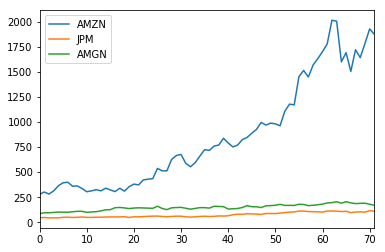

In [4]:
data.plot()

In [5]:
# calculate monthly returns
price = data.set_index('Date')
returns_monthly = (price/price.shift(1) - 1).dropna()
returns_monthly.head()

,AMZN,JPM,AMGN
Date,,,
7/1/13,0.084735,0.055692,0.097608
8/1/13,-0.067193,-0.086695,0.006002
9/1/13,0.112677,0.022957,0.031851
10/1/13,0.164374,-0.002902,0.037706
11/1/13,0.081284,0.118385,-0.017737


In [6]:
returns_monthly.describe()

,AMZN,JPM,AMGN
count,71.000000,71.000000,71.000000
mean,0.030672,0.014376,0.011597
std,0.084609,0.058435,0.063224
min,-0.202192,-0.131032,-0.153768
25%,-0.027752,-0.014334,-0.024058
50%,0.027685,0.013288,0.013238
75%,0.081967,0.048789,0.042656
max,0.240639,0.165937,0.154635


Text(0, 0.5, 'mean return')

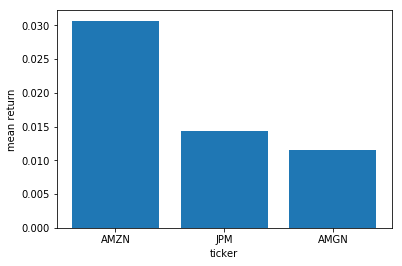

In [7]:
# plot mean returns
plt.figure(1)
plt.bar(np.arange(3), list(returns_monthly.describe().values[1]))
plt.xticks(np.arange(3), returns_monthly.describe().columns.values)
plt.xlabel('ticker')
plt.ylabel('mean return')

In [8]:
# save mean returns, standard deviations and covariance matrix
# for the following calculations
mean_list = list(returns_monthly.describe().values[1])
std_list = list(returns_monthly.describe().values[2])
covar = returns_monthly.cov().values

#### part B) Using simulation for random portfolio mixes, see risk/returns

In [9]:
# simulation of many weight vectors, calculate means and standard deviations based on them and
# save means and standard deviations into lists, respectively.
weight_list = np.arange(0, 1, 0.001)
mean_plot = []
std_plot = []
for weight1 in weight_list:
    weight2 = (1-weight1)*random.random()
    weight3 = 1 - weight1 - weight2
    mean_plot.append(weight1*mean_list[0] + weight2*mean_list[1] + weight3*mean_list[2])
    weight_vec = np.array([[weight1, weight2, weight3]]).transpose()
# matrix form: variance = w.T * covar * w
    std_plot.append(math.sqrt(np.linalg.multi_dot([weight_vec.transpose(), covar, weight_vec])))

In [10]:
# calculate the return and standard deviation of an equally weighted portfolio
eq_weight_mean = sum(mean_list)/3
eq_weight = np.array([[1/3, 1/3, 1/3]]).transpose()
eq_weight_std = math.sqrt(np.linalg.multi_dot([eq_weight.transpose(), covar, eq_weight]))
mean_tar = eq_weight_mean
print("eq weight mean =", "{0:.1%}".format(eq_weight_mean))
print("eq weight sd   =", "{0:.1%}".format(eq_weight_std))

eq weight mean = 1.9%
eq weight sd   = 5.2%


Text(0, 0.5, 'mean return')

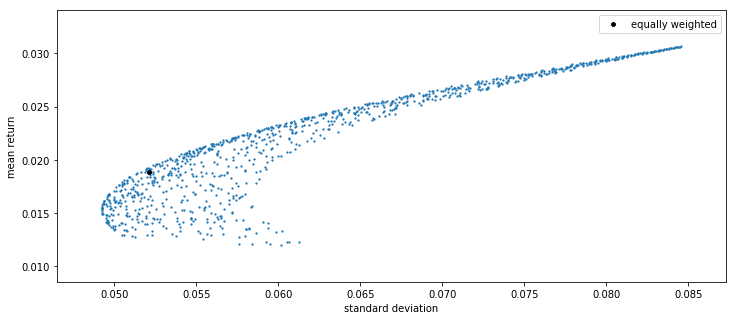

In [11]:
# plot all simulated portfolios
plt.figure(2, figsize = (12, 5))
plt.scatter(std_plot, mean_plot, s = 1.5)
plt.scatter(eq_weight_std, eq_weight_mean, s = 15, color = 'k', label = 'equally weighted')
plt.legend()
plt.xlabel('standard deviation')
plt.ylabel('mean return')

#### part C) Use optimization to trace out the family of optimal portfolios

In [12]:
# objective funtion: minimize standard deviation
def port_val(w, covar_matrix= covar):
    weight = np.array([w]).transpose()
    #print((math.sqrt(np.linalg.multi_dot([weight_vec, covar_matrix, weight_vec.transpose()]))))
    return (math.sqrt(np.linalg.multi_dot([weight.transpose(), covar_matrix, weight])))

In [13]:
# (lo,up) bounds on stock weights (no short selling)
bnds = ((0, 1), (0, 1), (0, 1))

In [14]:
# solve for the efficient frontier - run a family of QPs
weight1_list = [] # stock 1 weight [0, 1], for different minimum returns
weight2_list = [] # stock 2 weight
weight3_list = [] # stock 3 weight
eff_mean_list = [] # achieved return for each required return case
eff_std_list = [] # std dev of each required return case
for mean in np.arange(0.015, mean_list[0], 0.0001):
    cons = ({'type':'eq',
             'fun': lambda w: w[0]+ w[1]+ w[2] -1},
            {'type':'eq',
             'fun': lambda w: w[0]* mean_list[0]+ w[1]* mean_list[1]+ w[2]*mean_list[2] - mean})
    result = sco.minimize(port_val, [0.3, 0.3, 0.3], method = 'SLSQP',
                      bounds = bnds, constraints = cons)
    efficient_mean = mean_list[0]*result['x'][0] + mean_list[1]*result['x'][1]+ mean_list[2]*result['x'][2]
    efficient_std = result['fun']
    weight1_list.append(result['x'][0]*100)
    weight2_list.append(result['x'][1]*100)
    weight3_list.append(result['x'][2]*100)
    efficient_weight = np.array([result['x']])
    eff_mean_list.append(efficient_mean)
    eff_std_list.append(efficient_std)

Text(0, 0.5, 'portfolio weights(%)')

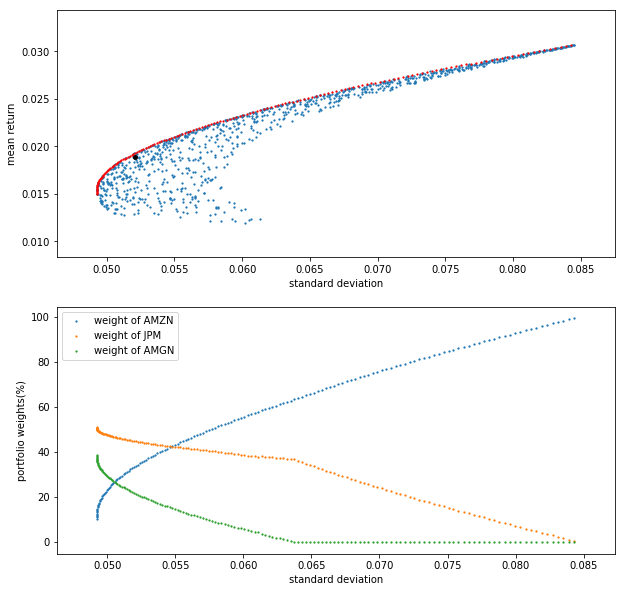

In [15]:
# plot efficient frontier - optimization boundary justaposed with simulation
plt.figure(3, figsize = (10, 10))
plt.subplot(2, 1, 1)
plt.scatter(std_plot, mean_plot, s = 1.5)
plt.scatter(eq_weight_std, eq_weight_mean, s = 15, color = 'k')
plt.scatter(eff_std_list, eff_mean_list, s = 1.5, color = 'r')
plt.xlabel('standard deviation')
plt.ylabel('mean return')
plt.subplot(2, 1, 2)
plt.scatter(eff_std_list, weight1_list, s = 1.5, label = 'weight of AMZN')
plt.scatter(eff_std_list, weight2_list, s = 1.5, label = 'weight of JPM')
plt.scatter(eff_std_list, weight3_list, s = 1.5, label = 'weight of AMGN')
plt.legend()
plt.xlabel('standard deviation')
plt.ylabel('portfolio weights(%)')